<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Andrea Flores Fernández y Tania Bell Nicholls.

**Fecha:** 09 de octubre del 2021.

**Expediente** : IF725449 y IF716767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Proyecto_TBell_AFlores.git

# Proyecto Simulación - Censo de Ingresos

## Descripción

> En este proyecto utilizaremos datos reales de un censo realizado en 1994. Los datos fueron extraídos por Barry Becker y Ronny Kohavi y el censo fue realizado en EEUU. Los datos consisten en información de personas adultas y tiene 14 variables como el nivel de educación, edad, género, ocupación, estado civil, etc. Hay datos sobre más de 48 mil personas. 

## Objetivos

> #### Objetivo General:
El objetivo de este proyecto es ver si hay una distribución de probabilidad dentro de los datos del censo realizado. Con esta información se pretende discernir si hay alguna tendencia en la información demográfica de las personas.

> #### Objetivo específico:
    > - Organizar y limpiar los datos proporcionados.
    > - Realizar la correlación entre los diferentes factores proporcionados en la base de datos con el ingreso de las personas.
    > - Incluso se puede analizar la influencia de la edad en los ingresos de las personas.
    > - Realizar una simulación para determinar las condiciones que llevan a un ingreso mayor a $50,000.

## Definición del Problema

>El ingreso de las personas es un factor que determina su estilo de vida. Sin importar el punto de vista sobre el aspecto económico y el capitalismo, la realidad es que en el mundo en el que vivimos, el dinero es muy importante ya que determinará en dónde vives, que comes, que haces, la familia que puedes tener, etc. A través de los datos proporcionados por el censo, queremos analizar si hay alguna correlación entre los aspectos de la vida de las personas y su ingreso. De esta manera, podremos saber si hay una manera de incrementar los ingresos obtenidos. 

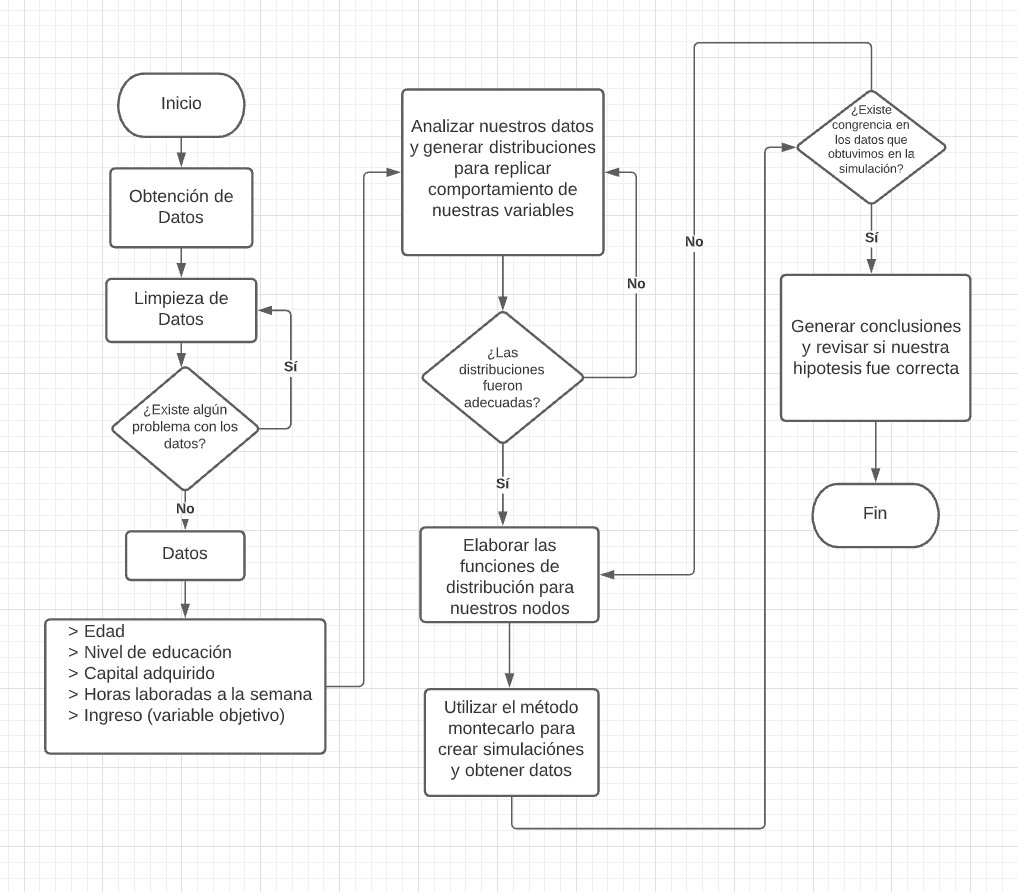

## Nodos y variables que se decidieron simular y por qué

>Para desarrollar el proyecto tomamos las siguientes variables:
    > - Edad
    > - Nivel de educación
    > - Capital adquirido
    > - Horas laboradas a la semana
    > - Ingreso (variable objetivo)

>De estas todas las variables que nos proporciona el dataset, filtramos las que no son numéricas y en la matriz de correlación que se realizó, se definieron las que más afectaban al ingreso; nuestra variable objetivo.

## Definición de hipótesis y supuestos

>Los supuestos que se dan por verdadero en nuestro proyecto son los siguientes:
    > - El ingreso define la calidad de vida de una persona.
    > - Las variables sólo son de personas adultas.
    > - Las variables que se analizarán son suficientes para determinar la condición ideal para determinar el ingreso.

>Nuestra hipótesis es que el factor que más influye en el ingreso de las personas es el nivel de educación.

## Obtención de bases de datos

> Los datos se obtuvieron de una plataforma de diferentes bases de datos llamada UCI Machine Learning Repository. La base de datos seleccionada es del censo realizado en EEUU del año 1994.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

data = pd.read_csv('adult.csv')
data = data[['age','educational-num','capital-gain','hours-per-week','income']].head(20001)
data

,age,educational-num,capital-gain,hours-per-week,income
0,25,7,0,40,0
1,38,9,0,50,0
2,28,12,0,40,1
3,44,10,7688,40,1
4,18,10,0,30,0
...,...,...,...,...,...
19996,21,10,0,20,0
19997,44,13,0,50,1
19998,29,13,0,40,0
19999,19,10,0,22,0


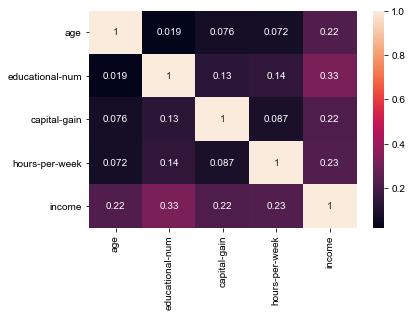

In [2]:
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, linewidths=.0001)
sn.set(rc = {'figure.figsize':(10,8)})
plt.show()

### Visualización de Variables

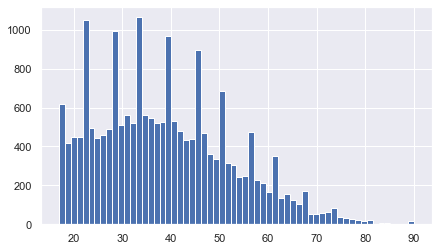

In [3]:
plt.figure(figsize=(7,4))
plt.hist(data['age'], bins = 60);

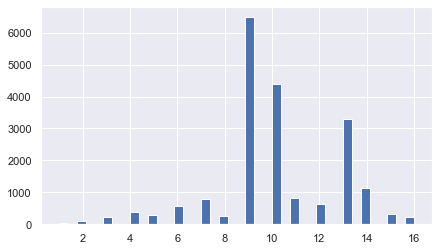

In [4]:
plt.figure(figsize=(7,4))
plt.hist(data['educational-num'], bins = 40);

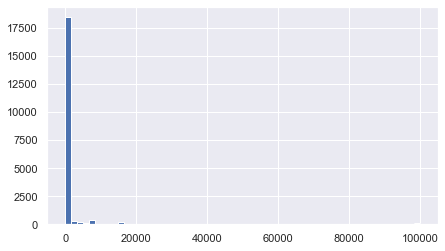

In [5]:
plt.figure(figsize=(7,4))
plt.hist(data['capital-gain'], bins = 60);

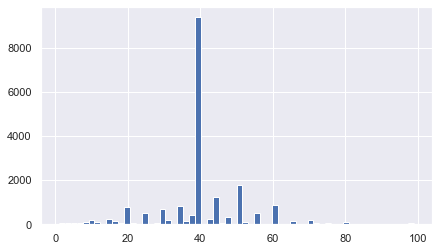

In [6]:
plt.figure(figsize=(7,4))
plt.hist(data['hours-per-week'], bins = 60);

Como se puede analizar en los histogramas anteriores, no tenemos una distribución clara, por lo tanto tenemos que hacer ajustes en la información para encontrar una tendencia. Esto lo haremos a través de el método de Kernel Density Estimation.

Primero analizaremos los box plots de nuestras variables para ver si tenemos muchos outliers.

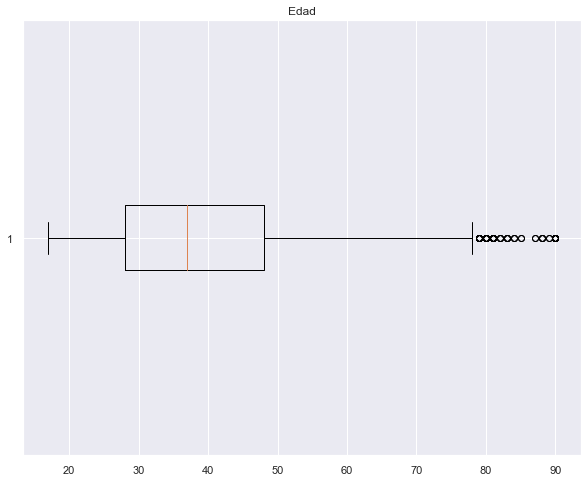

In [54]:
edad = np.array(data['age'])
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show()

In [55]:
edad = np.log(edad[edad>0])
edad = edad[~np.isnan(edad)]
edad

array([3.21887582, 3.63758616, 3.33220451, ..., 3.36729583, 2.94443898,
       3.04452244])

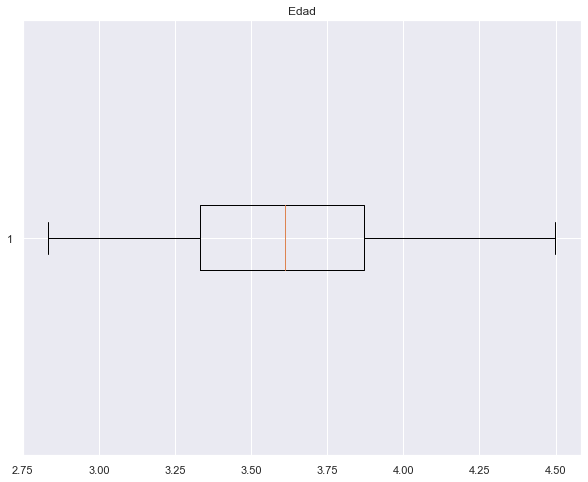

In [56]:
plt.boxplot(edad,vert=False)
plt.title('Edad')
plt.show()

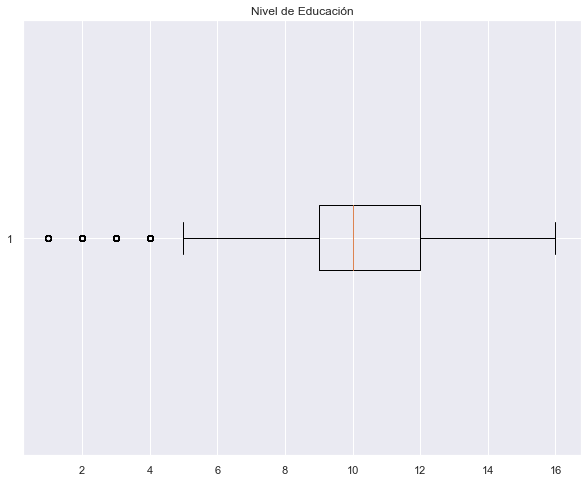

In [57]:
educacion = np.array(data['educational-num'])
plt.boxplot(educacion,vert=False)
plt.title('Nivel de Educación')
plt.show()

In [58]:
educacion = np.sqrt(educacion[educacion>0])
educacion = educacion[~np.isnan(educacion)]
educacion 

array([2.64575131, 3.        , 3.46410162, ..., 3.60555128, 3.16227766,
       3.16227766])

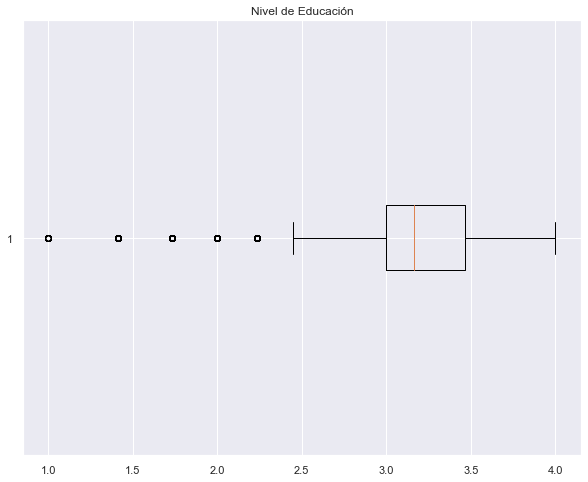

In [59]:
plt.boxplot(educacion,vert=False)
plt.title('Nivel de Educación')
plt.show()

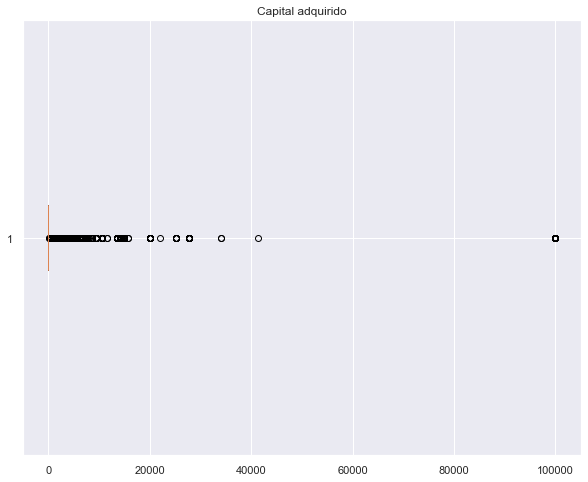

In [60]:
capital = np.array(data['capital-gain'])
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

In [61]:
capital = np.log(capital[capital>0])
capital = capital[~np.isnan(capital)]
capital

array([8.94741595, 8.04012466, 8.76686182, ..., 8.10922495, 8.89535562,
       8.39298959])

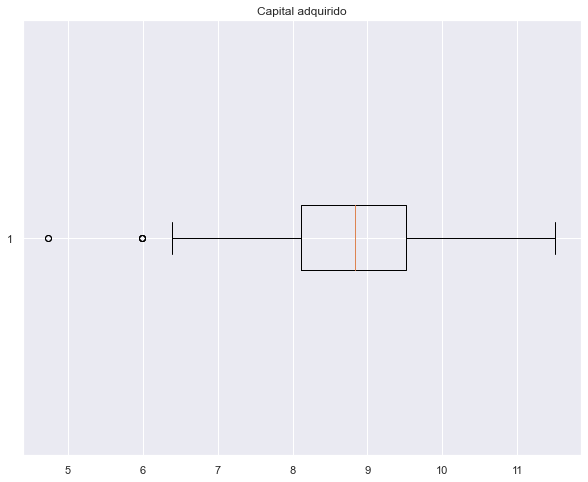

In [62]:
plt.boxplot(capital,vert=False)
plt.title('Capital adquirido')
plt.show()

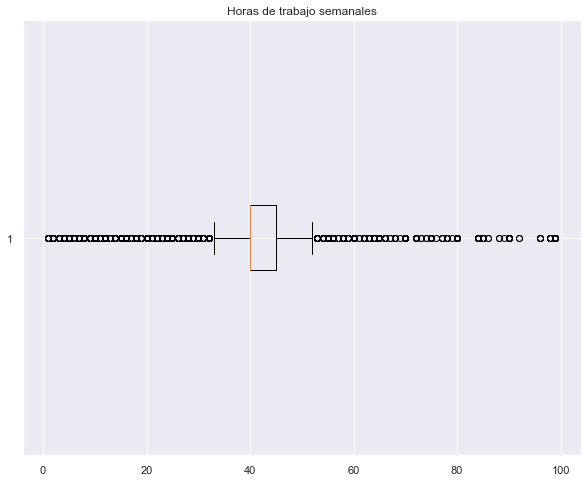

In [63]:
horas = np.array(data['hours-per-week'])
plt.boxplot(horas,vert=False)
plt.title('Horas de trabajo semanales')
plt.show()

In [64]:
horas = np.sqrt(horas[horas>0])
horas = horas[~np.isnan(horas)]
horas

array([6.32455532, 7.07106781, 6.32455532, ..., 6.32455532, 4.69041576,
       6.32455532])

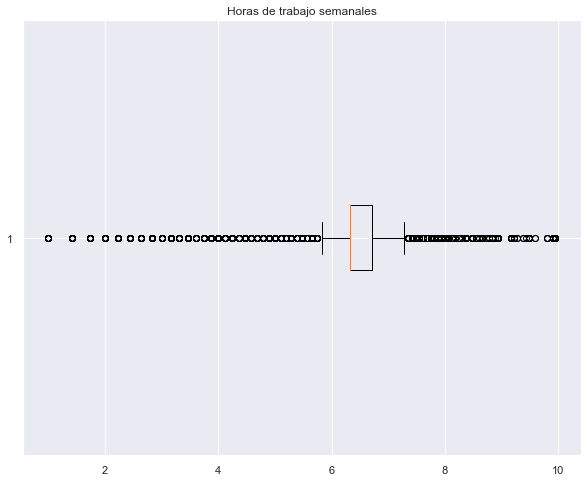

In [65]:
plt.boxplot(horas,vert=False)
plt.title('Horas de trabajo semanales')
plt.show()

En la mayoría de los box plots tenemos varios outliers entonces implementamos el método de KDE. Para ajustar los datos aplicaremos el logaritmo.

In [59]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

Encontramos el grid y bandwidth adecuado

#### Edad

In [82]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 100, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(edad[:, None])


GridSearchCV(cv=20, estimator=KernelDensity(),
             param_grid={'bandwidth': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])})

In [83]:
print(grid.best_params_)

{'bandwidth': 3.4482758620689653}


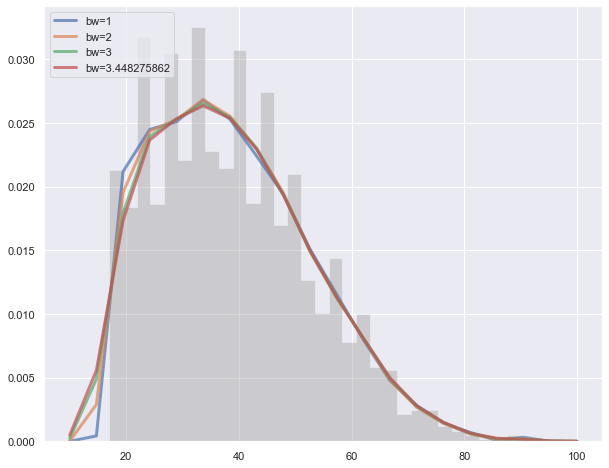

In [84]:
fig, ax = plt.subplots()
for bandwidth in [1, 2, 3, 3.448275862]:
    ax.plot(np.linspace(10,100,20), kde_sklearn(edad, np.linspace(10,100,20), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(edad, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
#ax.set_xlim(0,100)
ax.legend(loc='upper left')

#### Educación

In [85]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 200, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(educacion[:, None])

GridSearchCV(cv=20, estimator=KernelDensity(),
             param_grid={'bandwidth': array([  0.        ,   6.89655172,  13.79310345,  20.68965517,
        27.5862069 ,  34.48275862,  41.37931034,  48.27586207,
        55.17241379,  62.06896552,  68.96551724,  75.86206897,
        82.75862069,  89.65517241,  96.55172414, 103.44827586,
       110.34482759, 117.24137931, 124.13793103, 131.03448276,
       137.93103448, 144.82758621, 151.72413793, 158.62068966,
       165.51724138, 172.4137931 , 179.31034483, 186.20689655,
       193.10344828, 200.        ])})

In [86]:
print(grid.best_params_)

{'bandwidth': 6.896551724137931}


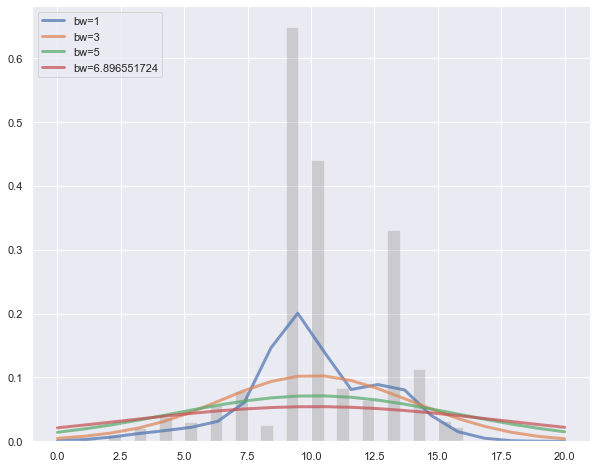

In [87]:
fig, ax = plt.subplots()
for bandwidth in [1, 3, 5, 6.896551724]:
    ax.plot(np.linspace(0,20,20), kde_sklearn(educacion, np.linspace(0,20,20), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(educacion, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
#ax.set_xlim(0,100)
ax.legend(loc='upper left')

#### Capital Adquirido

In [88]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 45000, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(capital[:, None])

GridSearchCV(cv=20, estimator=KernelDensity(),
             param_grid={'bandwidth': array([    0.        ,  1551.72413793,  3103.44827586,  4655.17241379,
        6206.89655172,  7758.62068966,  9310.34482759, 10862.06896552,
       12413.79310345, 13965.51724138, 15517.24137931, 17068.96551724,
       18620.68965517, 20172.4137931 , 21724.13793103, 23275.86206897,
       24827.5862069 , 26379.31034483, 27931.03448276, 29482.75862069,
       31034.48275862, 32586.20689655, 34137.93103448, 35689.65517241,
       37241.37931034, 38793.10344828, 40344.82758621, 41896.55172414,
       43448.27586207, 45000.        ])})

In [89]:
print(grid.best_params_)

{'bandwidth': 1551.7241379310344}


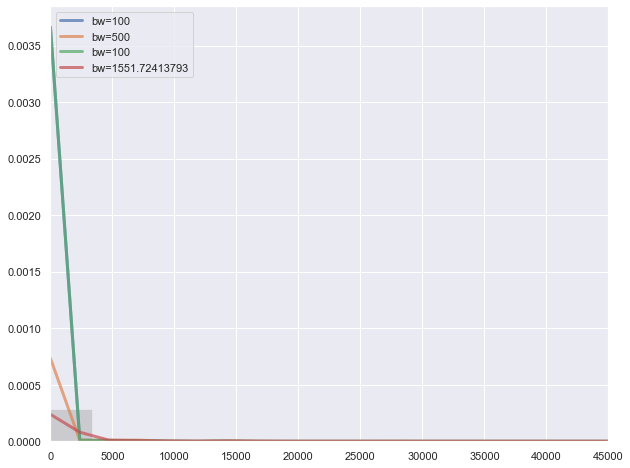

In [91]:
fig, ax = plt.subplots()
for bandwidth in [100, 500, 100, 1551.72413793]:
    ax.plot(np.linspace(0,45000,20), kde_sklearn(capital, np.linspace(0,45000,20), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(capital, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(0,45000)
ax.legend(loc='upper left')

#### Horas de trabajo a la semana

In [92]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 100, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(horas[:, None])

GridSearchCV(cv=20, estimator=KernelDensity(),
             param_grid={'bandwidth': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])})

In [93]:
print(grid.best_params_)

{'bandwidth': 3.4482758620689653}


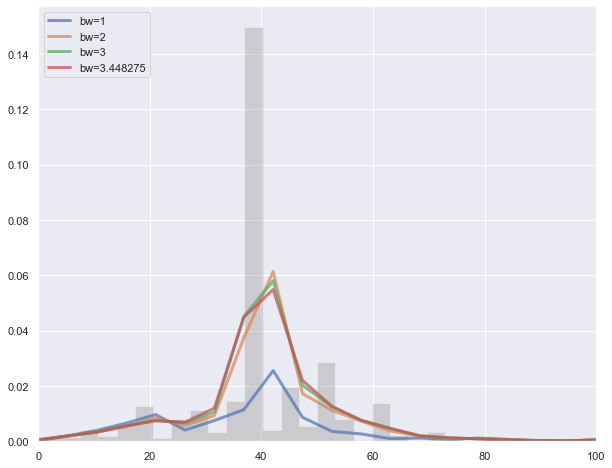

In [95]:
fig, ax = plt.subplots()
for bandwidth in [1, 2, 3, 3.448275]:
    ax.plot(np.linspace(0,100,20), kde_sklearn(horas, np.linspace(0,100,20), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(horas, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.set_xlim(0,100)
ax.legend(loc='upper left')

### Visualización de resultados de simulación

### Conclusiones

### Referencias

T.T.B. (2021, 4 agosto). Medical Insurance Premium Prediction. Recuperado 9 de octubre de 2021, de https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction